%load_ext autoreload
%autoreload 2

In [ ]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests

from decode_fish.funcs.merfish_eval import *
from starfish import data
import pprint

import io, requests
from sklearn.neighbors import NearestNeighbors

In [ ]:
bench = pd.read_csv(
    io.BytesIO(requests.get('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv').content),
    dtype={'barcode': object})

#See Fig. S4 https://www.pnas.org/content/113/39/11046

bench_df = bench.copy()
bench_df = bench_df[bench_df['total_magnitude']>10**0.75 * 4]
bench_df = bench_df[bench_df['area']>3]

print(len(bench_df))

experiment = data.MERFISH(use_test_data=True)
code_ref = experiment.codebook.data.reshape([140,-1], order='F')
targets = experiment.codebook.indexes['target']

13832


In [ ]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_c_01noise.csv')
pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[pred_df['frame_idx']>7] = shift_df(pred_df[pred_df['frame_idx']>7], [5,20,0])
pred_df.loc[:,'comb_sig'] = np.sqrt(pred_df['x_sig']**2 + pred_df['y_sig']**2)
len(pred_df)

206793

In [ ]:
def norm_features(code, norm_order = 2):
    
    norm = np.linalg.norm(code, ord=norm_order, axis=1)
    code = code / norm[:, None]

    return code

def approximate_nearest_code(ref_code, pred_code, targets):
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='euclidean').fit(ref_code)
    metric_output, indices = nn.kneighbors(pred_code)
    gene_ids = np.ravel(targets.values[indices])

    return np.ravel(metric_output), gene_ids, indices

In [ ]:
# Define points where to query. Something to replace pixels. Could do a fine grid. 

In [ ]:
import torch.tensor as T

def get_codes(pred_df, group_rad=150, prob_smoothing=1):
#     group_rad=150;
#     prob_smoothing=20;
    norm_code = norm_features(code_ref) 

    loc_df=pred_df.copy()

    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df = loc_df.sort_values('comb_sig').reset_index(drop=True)

    xy = loc_df.loc[:,['x','y']].values
    xy_sig = loc_df.loc[:,['x_sig','y_sig']].values * 0 + 25
    fr_idx = loc_df.loc[:,'frame_idx'].values
    grouped_bool = np.zeros(len(loc_df))

    tree = cKDTree(xy)
    code_errs = []

    seed_inds = []
    code_err = []
    code_ind = []

    for i in tqdm(range(len(loc_df))):
#     for i in range(10000):    
        if not grouped_bool[i]:

            ball_inds = np.array(tree.query_ball_point(xy[i], group_rad))
            ball_inds = ball_inds[grouped_bool[ball_inds] == 0]

            if len(ball_inds) >= 4:

                frame_probs = np.zeros(N_imgs)
                # Evaluate probs at the position of the seed localization
                probs = torch.exp(torch.distributions.normal.Normal(T(xy[ball_inds]), T(xy_sig[ball_inds])).log_prob(T(xy[i])).sum(-1))
                # If multiple localizations belong the same frame, chose the one with higehst prob.
                sort_inds = np.argsort(-probs)
                sort_fr_idx = fr_idx[ball_inds][sort_inds]
                unique_inds = sort_inds[np.unique(sort_fr_idx, return_index=True)[1]] 
                
                if len(unique_inds) >= 4:
                    
                    ball_inds = ball_inds[unique_inds]
                    frame_probs[fr_idx[ball_inds]] = probs[unique_inds]
                    
                    frame_probs = np.clip(frame_probs,0.,np.sort(frame_probs[frame_probs.nonzero()])[1])
                    frame_probs = frame_probs**(1/prob_smoothing)
                    code_errors = np.sqrt(((norm_code - norm_features(frame_probs[None]))**2).sum(-1))
                    min_ind = np.argmin(code_errors)

                    selected = ball_inds[np.intersect1d(fr_idx[ball_inds], code_ref[min_ind].nonzero()[0], assume_unique=True, return_indices=True)[1]]

                    code_ref[min_ind]
                    grouped_bool[selected] = 1

                    seed_inds.append(i)
                    code_err.append(code_errors[min_ind])
                    code_ind.append(min_ind)

    loc_df = loc_df.loc[seed_inds]
    loc_df['code_err'] = code_err
    loc_df['code_inds'] = code_ind
    loc_df['gene'] = targets[code_ind]

    return loc_df

In [ ]:
res_df = get_codes(pred_df, group_rad=150, prob_smoothing=20)

100%|█████████████████████████████████████████████████████| 206793/206793 [00:36<00:00, 5605.79it/s]


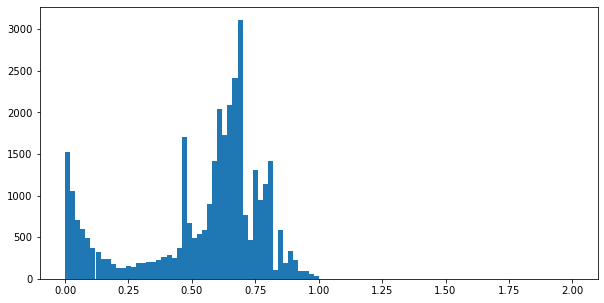

In [ ]:
plt.figure(figsize=(10,5))
_ = plt.hist(res_df['code_err'], bins=np.linspace(0,2,101))

In [ ]:
# res_df = res_df[:20000]

In [ ]:
x = np.linspace(1000,len(res_df),100)
max_blanks = res_df['gene'].str.contains('Blank').sum()
vardict = {'int':False, 'code_err':True}
rocs = {}

for v in vardict:
    
    res_df = res_df.sort_values(v, ascending=vardict[v])
    n_blanks = []
    for i in x:
        n_blanks.append((res_df[:int(i)]['gene'].str.contains('Blank')).sum())
    rocs[v] = n_blanks

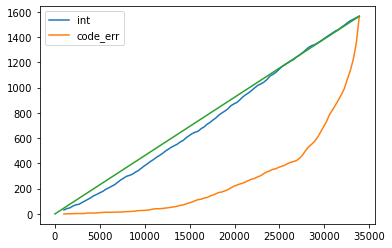

In [ ]:
for v in rocs:
    plt.plot(x, rocs[v], label=v)
plt.plot([0,len(res_df)],[0,max_blanks])
plt.legend()

In [ ]:
res_df[:15000]['gene'].str.contains('Blank').sum()

88

In [ ]:
bench_match = bench_df.copy()
bench_match.loc[:,'frame_idx'] = 0
bench_match.loc[:,'loc_idx'] = np.arange(len(bench_match))
bench_match.loc[:,'int'] = bench_match['total_magnitude']
bench_match.loc[:,'z'] = 50/100
bench_match = px_to_nm(bench_match)

res_df[:15000].loc[:,'frame_idx'] = 0

_,_,shift = matching(bench_match, res_df[:15000], tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))

_,_,shift = matching(bench_match, res_df[:15000], tolerance=250, print_res=False)

bench_match = shift_df(bench_match, shift=-np.array(shift))
_,matches,shift = matching(bench_match, res_df[:15000], tolerance=250, print_res=True)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Recall: 0.557
Precision: 0.514
Jaccard: 36.509
RMSE_vol: 100.532
Eff_3d: 19.020
FN: 6121.0 FP: 7289.0
Num. matches: 7711.000
Shift: 3.20,2.60,0.00
